#### Imports

In [1]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os

Using TensorFlow backend.


In [2]:
# pip install librosa

#### Reading the files from our folder and creating a dataframe from it

In [3]:
#list the files
filelist = os.listdir('male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [4]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [5]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [6]:
df_male.head()

,file,label
0,2893-139322-0000.flac,1
1,1034-121119-0071.flac,1
2,78-369-0018.flac,1
3,322-124147-0038.flac,1
4,831-130739-0049.flac,1


In [7]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


Doing the same for the female folder

In [8]:
filelist = os.listdir('female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [9]:
df_female['label']='0'

In [10]:
df_female = df_female.rename(columns={0:'file'})

In [11]:
df_female.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [12]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label
981,.DS_Store,0


In [13]:
# Dropping the system file
df_female.drop(981, inplace=True)

In [14]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

Joining both dataframes together 

In [15]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [16]:
df.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [17]:
# Randomizing our files to be able to split into train, validation and test
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [53]:
# We will be using our saved randomized df to replicate results
# Any randomized df can be used but we already had the features for this randomized df

# df = pd.read_csv('randomized_df.csv')

We are going to do an split of train, validation and test with 70% train, 20% validation and 10% for test. We check that the randomized splits have balanced classes

In [54]:
df_train = df[:9188]

In [55]:
df_train['label'].value_counts(normalize=True)

0    0.501633
1    0.498367
Name: label, dtype: float64

In [56]:
df_validation = df[9188:11813]

In [57]:
df_validation['label'].value_counts(normalize=True)

1    0.502476
0    0.497524
Name: label, dtype: float64

In [58]:
df_test = df[11813:13125]

In [59]:
df_test['label'].value_counts(normalize=True)

1    0.500762
0    0.499238
Name: label, dtype: float64

#### Function to extract the features and label for each sound file by iterating through every row of the dataframe

In [60]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [61]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [129]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [130]:
# Code to see how long it took
print(datetime.now() - startTime)

2:53:17.949280


In [33]:
# Checking how the output looks
features_label

array([(array([-366.63562   ,   96.04874   ,  -69.84662   ,   76.36943   ,
        -24.817017  ,   14.41616   ,    4.2905197 ,   -1.8795805 ,
         13.70058   ,    3.6543803 ,    8.991205  ,   -3.1601498 ,
          5.1049666 ,    2.6289887 ,    1.0638338 ,   -3.784181  ,
          1.1059349 ,    1.8543453 ,    2.2196708 ,    3.0452476 ,
          2.9182453 ,    4.099081  ,    0.39878955,    5.7587442 ,
          0.7864756 ,    3.3036218 ,    1.7996112 ,   -0.8484667 ,
          3.3366387 ,    2.934917  ,    2.9008343 ,    0.5252678 ,
          2.3906317 ,    1.9600887 ,    2.8523176 ,    3.2463658 ,
          3.8902597 ,    4.625333  ,    3.8027694 ,    5.2710724 ],
      dtype=float32), array([0.55214745, 0.5712805 , 0.598977  , 0.60294086, 0.61977226,
       0.6546082 , 0.64055675, 0.62010676, 0.586103  , 0.58701015,
       0.6026565 , 0.5885016 ], dtype=float32), array([7.36393154e-01, 2.26960018e-01, 1.12153115e-02, 6.72356132e-03,
       1.60283357e-01, 1.04996264e+00, 1.69271

In [132]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_label)

In [25]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)

In [62]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [63]:
len(features)

13125

In [64]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_label)):
    labels.append(features_label[i][5])

In [65]:
len(labels)

13125

#### Checking if we have balanced classes for the whole data

In [66]:
np.unique(labels, return_counts=True)

(array(['0', '1'], dtype='<U1'), array([6570, 6555]))

#### Hot encoding y and pre processing X and y

In [67]:
# Setting our X as a numpy array to feed into the neural network
X = np.array(features)

In [68]:
# Setting our y
y = np.array(labels)

In [69]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [70]:
# Checking our shapes
X.shape

(13125, 193)

In [71]:
# Checking our shapes
y.shape

(13125, 2)

In [72]:
# Choosing the first 9188 (70%) files to be our train data
# Choosing the next  2625 (20%) files to be our validation data
# Choosing the next  1312 (10%) files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:9188]
y_train = y[:9188]

X_val = X[9188:11813]
y_val = y[9188:11813]

X_test = X[11813:]
y_test = y[11813:]

Scaling our data

In [73]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

#### Building the neural network

In [74]:
# Build a simple dense model with early stopping with softmax for categorical classification
# Note that we use softmax for binary classification because it gives us a better result
# than sigmoid for our probabilities in case we decide to use a voting classifier 

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [75]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Train on 9188 samples, validate on 2625 samples
Epoch 1/100
9188/9188 [==============================] - 1s 88us/sample - loss: 0.2857 - accuracy: 0.8851 - val_loss: 0.0945 - val_accuracy: 0.9661
Epoch 2/100
9188/9188 [==============================] - 0s 18us/sample - loss: 0.0858 - accuracy: 0.9720 - val_loss: 0.0461 - val_accuracy: 0.9855
Epoch 3/100
9188/9188 [==============================] - 0s 18us/sample - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.0293 - val_accuracy: 0.9920
Epoch 4/100
9188/9188 [==============================] - 0s 18us/sample - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0237 - val_accuracy: 0.9935
Epoch 5/100
9188/9188 [==============================] - 0s 17us/sample - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0223 - val_accuracy: 0.9928
Epoch 6/100
9188/9188 [==============================] - 0s 16us/sample - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0339 - val_accuracy: 0.9909
Epoch 7/100
9188/9188 [==============================] - 0s 18us

In [76]:
# Checking how our model looks like and how many parameters it has
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 193)               37442     
_________________________________________________________________
dropout_3 (Dropout)          (None, 193)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

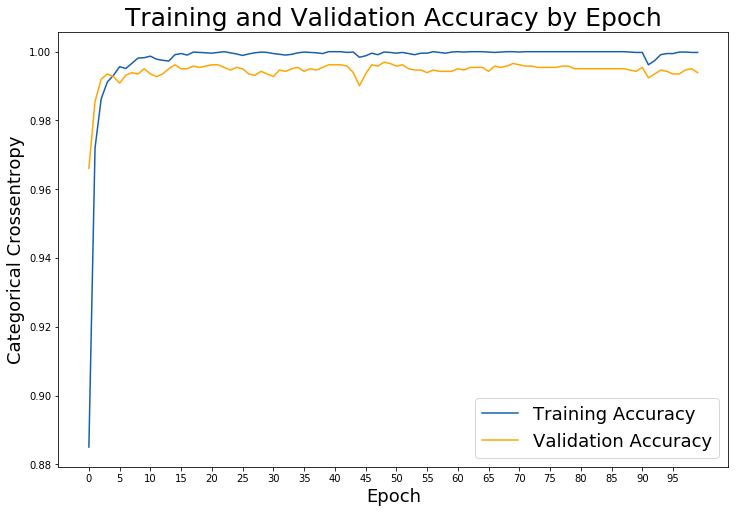

In [77]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [78]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

In [79]:
df_test = df[11813:]

In [80]:
df_test['preds'] = preds

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
df_test

,file,label,preds
11813,2518-154826-0031.flac,1,1
11814,254-127705-0028.flac,1,1
11815,374-180298-0041.flac,1,1
11816,1926-143879-0008.flac,0,0
11817,1116-132847-0002.flac,0,0
...,...,...,...
13120,1743-142914-0013.flac,1,1
13121,27-123349-0032.flac,1,1
13122,1898-145724-0026.flac,0,0
13123,2182-181183-0001.flac,0,0


In [82]:
df_test['label'] = df_test['label'].astype(int)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
# Slicing our dataframe into the files we got wrong from our predictions
df_test[df_test['label'] != df_test['preds']]

,file,label,preds
11982,1743-142912-0035.flac,1,0
12330,3436-172162-0001.flac,1,0
12522,250-142276-0000.flac,0,1


In [84]:
1-round(len(df_test[df_test['label'] != df_test['preds']])/len(df_test),3)

0.998

#### 99.8% accurate on test data

But it is test data from the speakers we have trained the model on

In [85]:
#Checking how many different speakers we have

speakers = []
for i in range(0, len(df)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(df['file'][i].split('-')[0])

len(set(speakers))

115

#### We will try again and add new test data with speakers that our model has never heard before

In [86]:
#list the files
filelist = os.listdir('test_male') 
#read them into pandas
df_test_male = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_male['label']=1

# Renaming the column name to file
df_test_male = df_test_male.rename(columns={0:'file'})

df_test_male.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_male[df_test_male['file']=='.DS_Store']

,file,label
6,.DS_Store,1


In [87]:
# Dropping the system file
df_test_male.drop(6, inplace=True)

# Resetting the index since we dropped a row
df_test_male = df_test_male.reset_index(drop=True)

In [88]:
df_test_male.head()

,file,label
0,5104-33406-0000.flac,1
1,5192-19396-0000.flac,1
2,3607-29116-0008.flac,1
3,6181-216552-0000.flac,1
4,5390-24512-0000.flac,1


In [89]:
#list the files
filelist = os.listdir('test_female') 
#read them into pandas
df_test_female = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_female['label']=0

# Renaming the column name to file
df_test_female = df_test_female.rename(columns={0:'file'})

df_test_female.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_female[df_test_female['file']=='.DS_Store']

,file,label
7,.DS_Store,0


In [90]:
# Dropping the system file
df_test_female.drop(7, inplace=True)

# Resetting the index since we dropped a row
df_test_female = df_test_female.reset_index(drop=True)

In [91]:
df_test_female.head()

,file,label
0,2910-131096-0007.flac,0
1,5778-12761-0000.flac,0
2,4680-16026-0000.flac,0
3,6272-70168-0000.flac,0
4,5867-48852-0000.flac,0


In [92]:
test_new = pd.concat([df_test_male, df_test_female], ignore_index=True)

In [93]:
test_new.head()

,file,label
0,5104-33406-0000.flac,1
1,5192-19396-0000.flac,1
2,3607-29116-0008.flac,1
3,6181-216552-0000.flac,1
4,5390-24512-0000.flac,1


In [94]:
#Checking how many different new speakers we have

speakers = []
for i in range(0, len(test_new)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(test_new['file'][i].split('-')[0])

len(set(speakers))

100

In [95]:
# Again, the modified function to extract features from our new test data

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('new_test_male_female')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [98]:
# Extracting the features of our new test data
features_label_test_new = test_new.apply(extract_features, axis=1)

In [99]:
os.system('say -v Samantha done');

In [100]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 
# Note that we are not using the label at all even though we kept it in the dataframe
# for comparisson and accuracy verification

features_new_test = []
for i in range(0, len(features_label_test_new)):
    features_new_test.append(np.concatenate((features_label_test_new[i][0], features_label_test_new[i][1], 
                features_label_test_new[i][2], features_label_test_new[i][3],
                features_label_test_new[i][4]), axis=0))

In [101]:
X_new_test = np.array(features_new_test)

In [102]:
X_new_test = ss.transform(X_new_test)

In [103]:
preds_new_test = model.predict_classes(X_new_test)

In [104]:
test_new['preds'] = preds_new_test

In [105]:
test_new[test_new['label'] != test_new['preds']]

,file,label,preds
35,4406-16882-0000.flac,1,0
67,5561-39621-0028.flac,0,1
76,6531-61334-0037.flac,0,1


In [106]:
1-round(len(test_new[test_new['label'] != test_new['preds']])/len(test_new),2)

0.97

#### We got 97% accuracy on our new speakers